In [24]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

In [25]:
# Example values for the probabilities
x = torch.tensor([[9/25,12/25,4/25],[2.,1/4,1/5]],requires_grad=True)
y = torch.tensor([[1/3,1/3,1/3],[2.,5/4,1/5]])
print(x)
print(y)

tensor([[0.3600, 0.4800, 0.1600],
        [2.0000, 0.2500, 0.2000]], requires_grad=True)
tensor([[0.3333, 0.3333, 0.3333],
        [2.0000, 1.2500, 0.2000]])


In [26]:
# Example of divergence being infinity
#x = torch.tensor([[-0.7753, -0.7236, -0.6072, -0.8284, -0.8085, -0.8923, -0.6853, -0.8315,-0.8302, -0.7934]])
#y = torch.tensor([[-9.7151e+00, -7.6585e+00, -7.3228e+00, -7.9473e-08, -1.0569e+01,-6.7095e+00, -1.1969e+01, -7.1102e+00, -5.1660e+00, -6.2902e+00]])
#print(x)
#print(y)

In [27]:
# Definition of Renyi Divergence with logits as input
class RenyiDivergence(nn.Module):
    def __init__(self, alpha=0.5):
        super(RenyiDivergence, self).__init__()
        self.alpha = alpha

    def forward(self, logits_p, logits_q):
        if self.alpha == 1.0: # KL Divergence
            log_sums = torch.logsumexp(logits_q, dim=1)-torch.logsumexp(logits_p, dim=1)
            
            exp_logits_p = torch.exp(logits_p)
            sum_exp_p = exp_logits_p.sum(dim=1, keepdim=True)
            
            loss = torch.sum((exp_logits_p / sum_exp_p) * (logits_p - logits_q + log_sums.unsqueeze(1)), dim=1)
            
            return loss.mean()
        
        exp_p = torch.exp(logits_p)
        exp_q = torch.exp(logits_q)
        
        power_p = exp_p.pow(self.alpha)
        power_q = exp_q.pow(1-self.alpha)
        
        sum_exp_p = torch.sum(exp_p,dim=1)
        sum_exp_q = torch.sum(exp_q,dim=1)
        
        loss = 1/(self.alpha-1) * (torch.log(torch.sum(power_p*power_q,dim=1)) - self.alpha*torch.log(sum_exp_p) + (self.alpha-1)*torch.log(sum_exp_q))
        
        return loss.mean()

In [28]:
# Test
output = RenyiDivergence(alpha=10)(x,y)
print(output)
output.backward()

tensor(0.1249, grad_fn=<MeanBackward0>)


In [29]:
## Preparation for plot creation
Q = torch.tensor([[1/3,2/3]])
Q = torch.log(Q)
lists = []
for alpha in [0.5,1,2,10]:
    list = []
    for p in range(501):
        P = torch.tensor([[p/500,1-p/500]])
        P = torch.log(P)
        divergence = RenyiDivergence(alpha=alpha)(P,Q)
        list.append(divergence)
    lists.append(list)
    
for p in range(501):
    list = []
    P = torch.tensor([[p/500,1-p/500]])

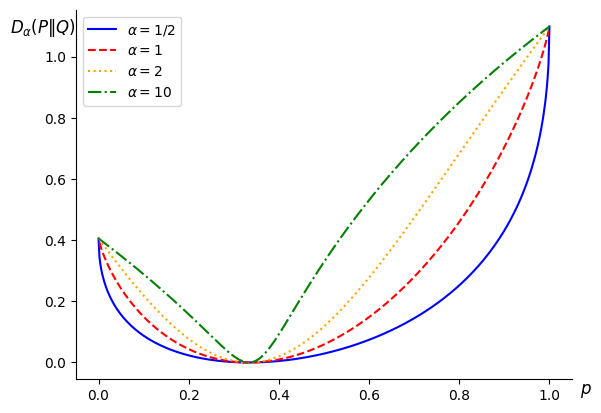

In [30]:
## Ploting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[0])), color='blue', linestyle='-', label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[1])), color='red', linestyle='--', label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[2])), color='orange', linestyle=':', label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[3])), color='green', linestyle='-.', label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$p$', xy=(1.05, 0), xytext=(10, -20), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 1.05), xytext=(-40, 10), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.legend()

fig.savefig('Renyi_Divergence.png')

plt.show()

In [33]:
# Define transforms for the training and test sets
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(14*14, 256)  # First fully connected layer (28*28 input to 128 neurons)
        self.fc2 = nn.Linear(256, 128)     # Second fully connected layer (128 input to 64 neurons)
        self.fc3 = nn.Linear(128, 10)      # Output layer (64 input to 10 output neurons)

    def forward(self, x):
        x = x.view(-1, 14*14)  # Flatten the image
        x = F.relu(self.fc1(x)) # Apply ReLU activation
        x = F.relu(self.fc2(x)) # Apply ReLU activation
        x = self.fc3(x)         # Output logits
        return F.log_softmax(x, dim=1)  # Apply log_softmax for classification


In [39]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients
        output = model(data)   # Forward pass
        loss = nn.CrossEntropyLoss()(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


In [47]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss(reduction = "sum")(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

In [48]:
## Train the teacher model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

for epoch in range(1, 8):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307327
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.692099
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.628599
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.556331
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.541220
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.201423
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.441957
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.639612
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.184885
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.276810

Test set: Average loss: 0.2710, Accuracy: 9211/10000 (92.11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.232634
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.258434
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.293327
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.126490
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.255422
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.307425
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.319550
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.156756
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.22745

In [49]:
class Reduced_Net(nn.Module):
    def __init__(self):
        super(Reduced_Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7, 8)  # First fully connected layer (28*28 input to 8 neurons)
        self.fc2 = nn.Linear(8, 6)     # Second fully connected layer (8 input to 6 neurons)
        self.fc3 = nn.Linear(6, 10)      # Output layer (6 input to 10 output neurons)

    def forward(self, x):
        x = self.pool(x)
        x = x.view(-1, 7*7)  # Flatten the image
        x = F.relu(self.fc1(x)) # Apply ReLU activation
        x = F.relu(self.fc2(x)) # Apply ReLU activation
        x = self.fc3(x)         # Output logits
        return F.log_softmax(x, dim=1)  # Apply log_softmax for classification


In [50]:
def destilation_train_and_test(student_model, teacher_model, device, train_loader, test_loader, optimizer, epoch, beta, temperature, alpha):
    student_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients
        with torch.no_grad():
            teacher_model_output = teacher_model(data)
        output = student_model(data)   # Forward pass
        loss = beta * RenyiDivergence(alpha=alpha)(output/temperature, teacher_model_output/temperature) + nn.CrossEntropyLoss()(output, target)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            
            
            student_model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = student_model(data)
                    teacher_model_output = teacher_model(data)
                    test_loss += beta * RenyiDivergence(alpha)(output/temperature, teacher_model_output/temperature) + nn.CrossEntropyLoss(reduction="sum")(output, target)
                    pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
        
            test_loss /= len(test_loader.dataset)
            accuracy = 100. * correct / len(test_loader.dataset)
            print(f'\tValidation loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
            wandb.log({"loss": loss.item(),"val_loss": test_loss, "val_accuracy": accuracy,"epoch": epoch})
            student_model.train()
            
def train_and_test(model, device, train_loader, test_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients
        output = model(data)   # Forward pass
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
            
            
            model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    test_loss += nn.CrossEntropyLoss(reduction="sum")(output, target)
                    pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
        
            test_loss /= len(test_loader.dataset)
            accuracy = 100. * correct / len(test_loader.dataset)
            print(f'\tValidation loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
            wandb.log({"loss": loss.item(),"val_loss": test_loss, "val_accuracy": accuracy,"epoch": epoch})
            model.train()
    

In [57]:
reduced_model = Reduced_Net().to(device)
optimizer = optim.SGD(reduced_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

wandb.init(
    project="Renyi_Divergence_MNIST",
    name = "Reduced Model",
    config={}
)

for epoch in range(1, 3):
    train_and_test(reduced_model, device, train_loader, test_loader, optimizer, epoch)
    test(reduced_model, device, test_loader)
    
wandb.finish()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312280
	Validation loss: 2.3743, Accuracy: 971/10000 (9.71%)

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.144859
	Validation loss: 2.1645, Accuracy: 3462/10000 (34.62%)

Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.514390
	Validation loss: 1.4349, Accuracy: 4972/10000 (49.72%)

Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.311840
	Validation loss: 1.0306, Accuracy: 6065/10000 (60.65%)

Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.641097
	Validation loss: 0.8422, Accuracy: 6830/10000 (68.30%)

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.808447
	Validation loss: 0.7174, Accuracy: 7455/10000 (74.55%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.632243
	Validation loss: 0.6461, Accuracy: 7807/10000 (78.07%)

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.581435
	Validation loss: 0.6489, Accuracy: 7829/10000 (78.29%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.498133
	Validation loss: 0.6290, Accuracy: 7860/10000 (78.60%)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.35

epoch,▁▁▁▁▁▁▁▁▁▁██████████
loss,█▇▅▄▂▃▂▂▂▁▂▂▂▁▂▂▃▁▂▁
val_accuracy,▁▃▅▆▇▇▇▇████████████
val_loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,2
loss,0.37227
val_accuracy,83
val_loss,0.50344


In [58]:
beta = 5
temperature = 10
alpha = 0.5

student_model = Reduced_Net().to(device)
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

wandb.init(
    project="Renyi_Divergence_MNIST",
    name = "Distilled Model",
    config={
        "beta": beta,
        "temperature": temperature,
        "alpha": alpha
    }
)

for epoch in range(1, 3):
    destilation_train_and_test(student_model, model, device, train_loader, test_loader, optimizer, epoch, beta, temperature, alpha)
    test(student_model, device, test_loader)
    
wandb.finish()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.635585
	Validation loss: 2.3196, Accuracy: 1091/10000 (10.91%)

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.435403
	Validation loss: 2.0626, Accuracy: 2342/10000 (23.42%)

Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.025367
	Validation loss: 1.6595, Accuracy: 3821/10000 (38.21%)

Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.690081
	Validation loss: 1.4170, Accuracy: 4864/10000 (48.64%)

Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.260876
	Validation loss: 1.2121, Accuracy: 5488/10000 (54.88%)

Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.209274
	Validation loss: 1.0643, Accuracy: 6195/10000 (61.95%)

Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.079097
	Validation loss: 0.9826, Accuracy: 6587/10000 (65.87%)

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.952281
	Validation loss: 0.9151, Accuracy: 6648/10000 (66.48%)

Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.009228
	Validation loss: 0.8374, Accuracy: 7259/10000 (72.59%)

Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.

epoch,▁▁▁▁▁▁▁▁▁▁██████████
loss,█▇▆▅▄▃▃▃▃▃▂▂▂▂▂▂▁▃▂▁
val_accuracy,▁▂▄▅▅▆▆▆▇▇▇█████████
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,2
loss,0.45325
val_accuracy,83.1
val_loss,0.52921


In [ ]:
## Some more testing with temperature

In [194]:
for batch_idx, (data, target) in enumerate(train_loader):
    student_model.eval()
    with torch.no_grad():
        output = student_model(data[0].to(device))
        teacher_model_output = model(data[0].to(device))
    break

Text(0.5, 1.0, 'Logits')

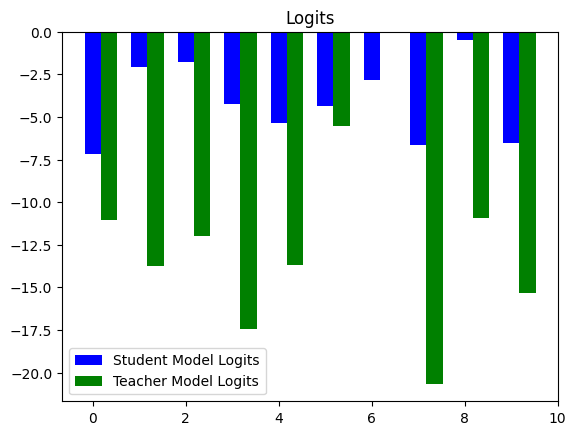

In [195]:
plt.bar(np.arange(10), np.squeeze(output.cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(teacher_model_output.cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Logits")

Text(0.5, 1.0, 'Sotmax without temperature')

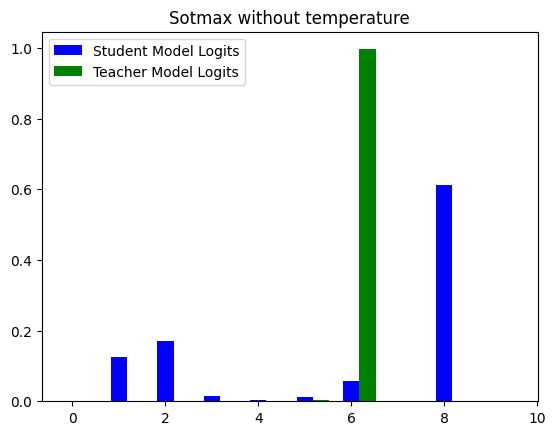

In [196]:
plt.bar(np.arange(10), np.squeeze(torch.softmax(output,dim=1).cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(torch.softmax(teacher_model_output,dim=1).cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Sotmax without temperature")

Text(0.5, 1.0, 'Sotmax with temperature')

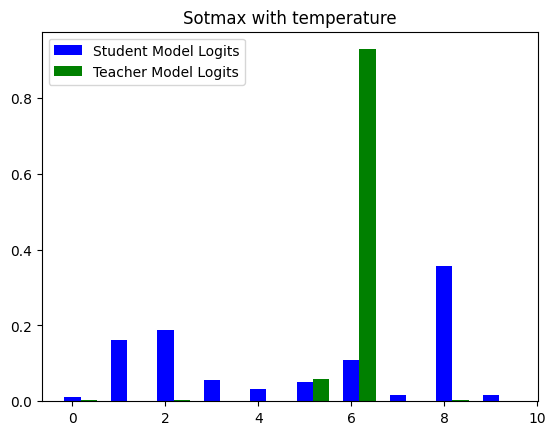

In [200]:
temperature = 2

plt.bar(np.arange(10), np.squeeze(torch.softmax(output/temperature,dim=1).cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(torch.softmax(teacher_model_output/temperature,dim=1).cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Sotmax with temperature")